In [1]:
#Initate connectiong to spark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt 
from shapely.geometry import Point, Polygon

In [2]:
#Change core max and core min to equal to eachother for scalibility tests
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.74:7077") \
        .appName("uber_application")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max",2)\
        .config("spark.cores.min",2)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/18 14:37:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/18 14:38:03 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


# Task 1) Find highest pickup frequencies for month, day, hour

In [3]:
#function to run all 
def plotwfreq(rides):
    #

    # remortamt Date/time to -> Month , day , hour 
    #The date given is M/D/Y , we use F.split to split the text string from Date/Time based on delimeter thus creating an "list" and picking relevant item, note that hour requires several Split.

    df1 = rides.withColumn('year', F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(0)) \
           .withColumn('month', F.split(rides['Date/Time'], '/').getItem(0)) \
           .withColumn('day', F.split(rides['Date/Time'], '/').getItem(1)) \
           .withColumn('hour', F.split(F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(1),':').getItem(0)) \
           .withColumn('minute', F.split(F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(1),':').getItem(1)) \


    df1 = df1.select([F.col(c).cast('integer') if c in ['year','month','day','hour','minute'] else c for c in df1.columns]) #casts as integer. 
    df1=df1.withColumn('weekday',F.date_format(F.concat(F.col("year"),F.lit("-"),F.col("month"),F.lit("-"),F.col("day")),'E'))
    
    #
    #Creating a table with #Day #Hour #weekday #ride_count

    hour_rides = df1.select('year','month','weekday','day','hour')

    # Checking what times of the day for weekdays troughout the month 
    hour_rides_count = hour_rides.groupBy('year','month','weekday','hour').count()
    hour_count = hour_rides.groupBy('hour').count().sort('hour')
    weekday_count = hour_rides.groupBy('weekday').count().sort('weekday')
    months=hour_rides.select('month').distinct().rdd.flatMap(lambda x: x).collect() #getting month 
    numberofmonth=months[0]
    #load to pandas dataframe 

    fig, axs = plt.subplots(2,figsize=(12,9)) # 2x2 grid 
    #Get values from DF previous and plot them 
    hour_pandasDF = hour_count.toPandas()
    axs[0].bar(hour_pandasDF['hour'],hour_pandasDF['count'])
    axs[0].set_title(f'Total hours for day Uber month : {numberofmonth}')
    axs[0].set_ylabel(f'Total hours driven')
    axs[0].set_xlabel(f'Hour of day')
    axs[0].set_xticks(hour_pandasDF['hour'],minor=False)
    

    #Plot weekdays 
    weekday_pandasDF = weekday_count.toPandas()
    axs[1].bar(weekday_pandasDF['weekday'],weekday_pandasDF['count'])
    axs[1].set_title(f'Total hours for week Uber month : {numberofmonth}')
    axs[1].set_ylabel(f'Total hours driven')
    axs[1].set_xlabel(f'Day of week')
    axs[1].set_xticks(weekday_pandasDF['weekday'],minor=False)
    plt.tight_layout()
    plt.show()
    
    ##########################
    #Weekday hourly averages

    wh_avg = hour_rides.groupBy('day','hour','weekday').count()
    wh_avg_pandas = wh_avg.toPandas() #converting to pandas 


    #Taking the average for a better plot  
    wh_avg_pandas = wh_avg_pandas.groupby(['weekday','hour'])['count'].mean() #average of weekday,hour

    wh_avg_pandas = wh_avg_pandas.reset_index()
    wh_avg_pandas = wh_avg_pandas.rename(columns = {'count':'count_avg'})
    
    fig = plt.figure(figsize=(12,6))
    ax2 = fig.add_subplot(1,1,1)
    sns.pointplot( x='hour',y='count_avg',hue='weekday', data = wh_avg_pandas,figsize=(12,8))

    ## format plot labels
    ax2.set_title(f'Weekday Averages for month:{numberofmonth}')
    ax2.set_ylabel('Rides per Hour')
    ax2.set_xlabel('Hour')
    
    plt.plot()

In [4]:
def plot_all():
    allrides = ['uber-raw-data-apr14.csv','uber-raw-data-may14.csv','uber-raw-data-jun14.csv','uber-raw-data-jul14.csv','uber-raw-data-aug14.csv','uber-raw-data-sep14.csv']
    for i in allrides:
        ride=spark_session.read\
        .option("header", "true")\
        .csv(f'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/{i}')
        print(f'Dataset :{i}')
        plotwfreq(ride)

Dataset :uber-raw-data-apr14.csv


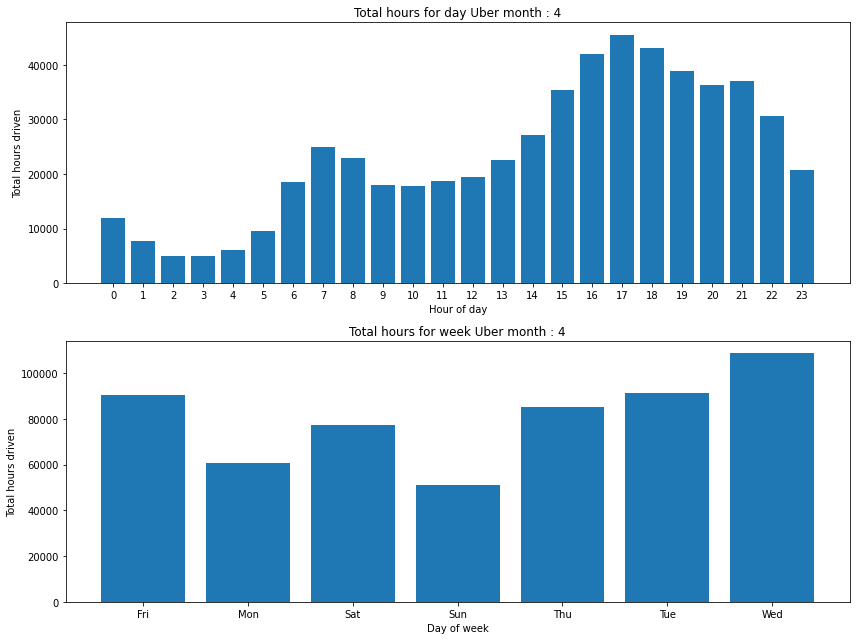

Dataset :uber-raw-data-may14.csv


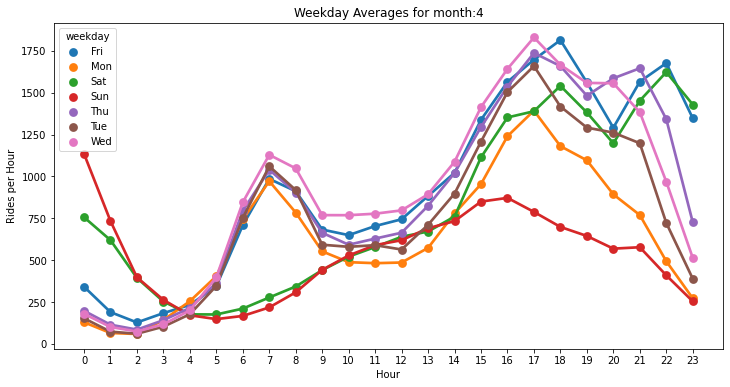

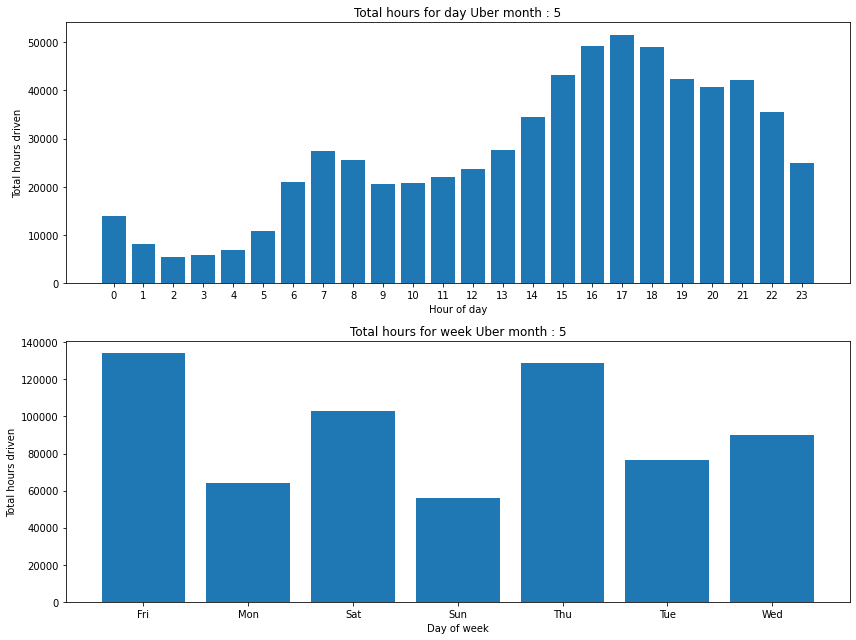

Dataset :uber-raw-data-jun14.csv


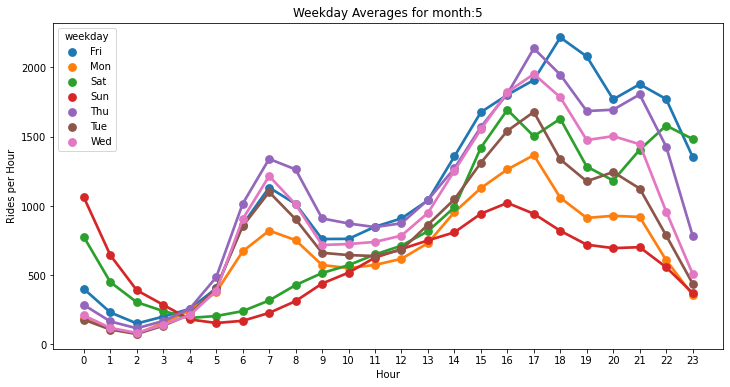

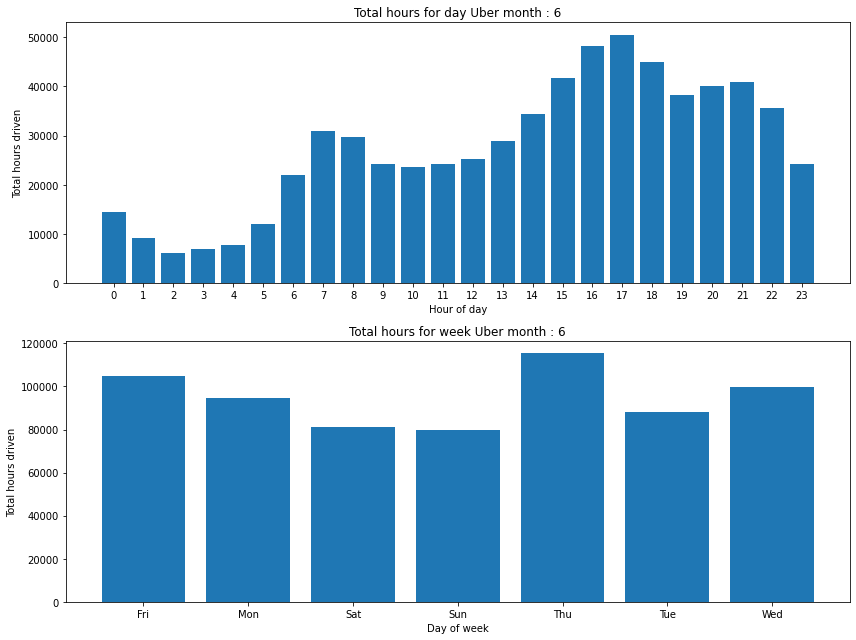

Dataset :uber-raw-data-jul14.csv


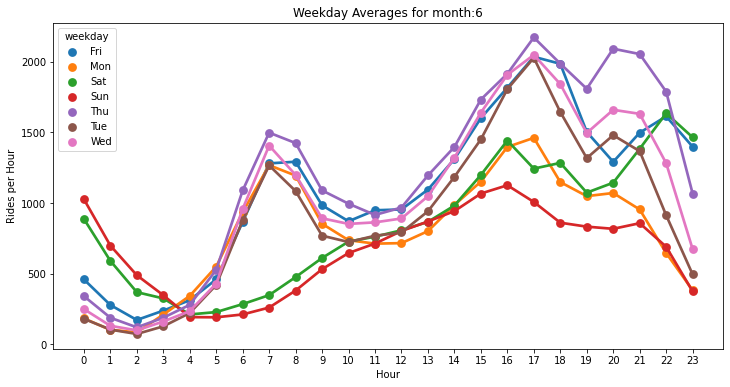

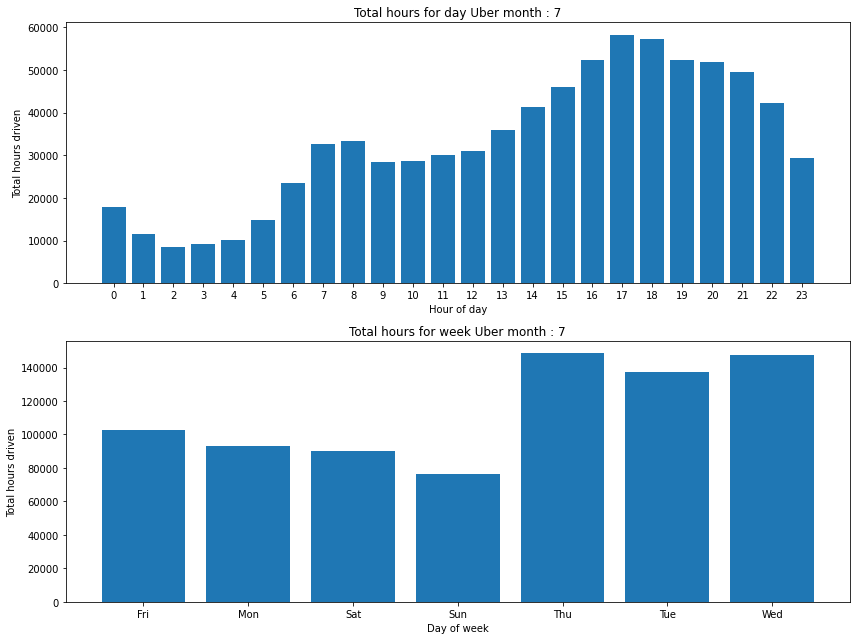

Dataset :uber-raw-data-aug14.csv


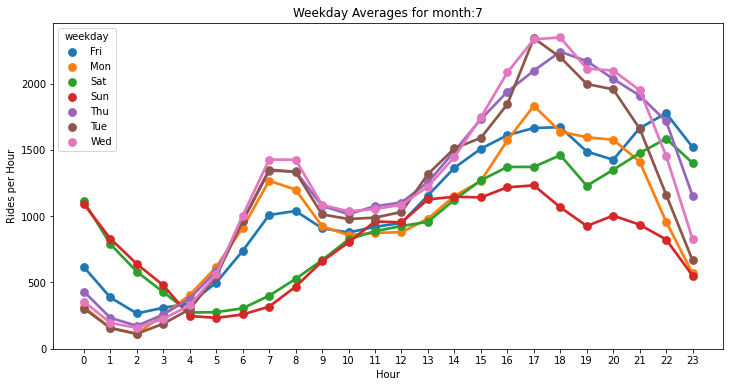

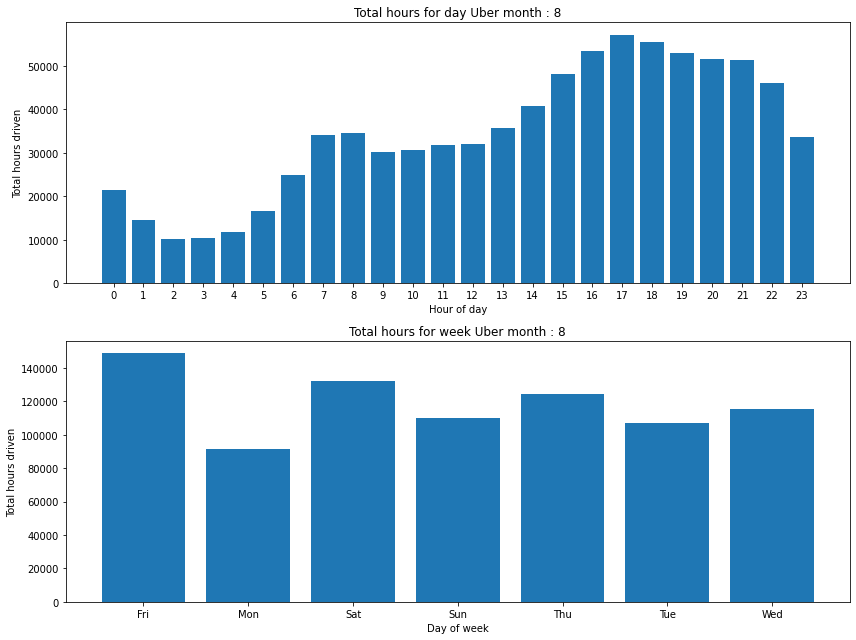

Dataset :uber-raw-data-sep14.csv


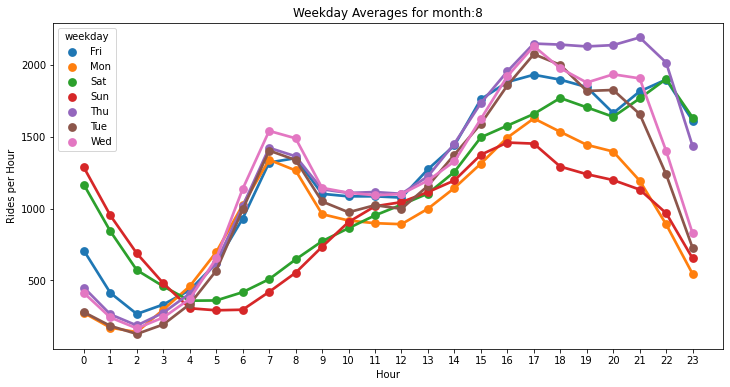

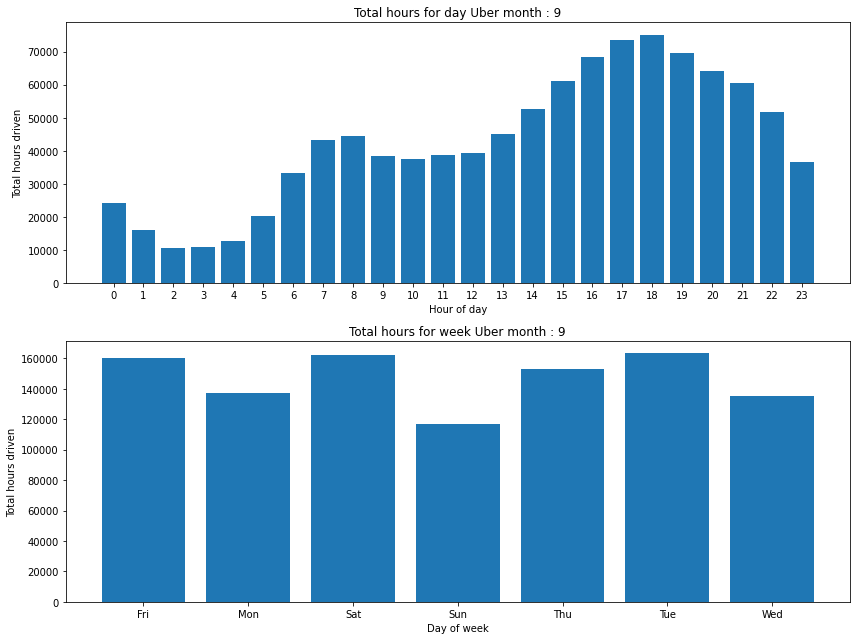

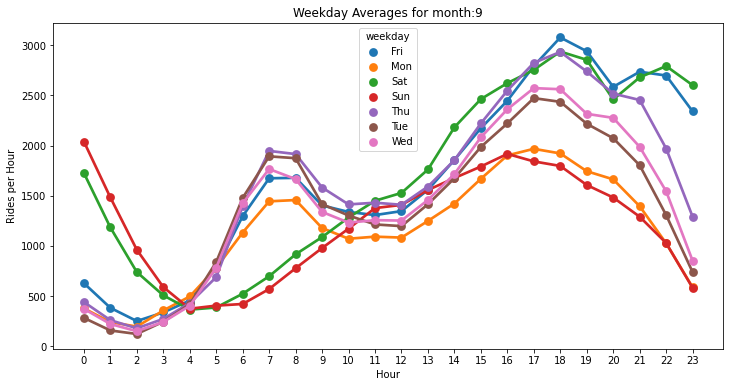

In [5]:
plot_all()

# 2) Find most popular companies

In [6]:
def find_most_popular_comp(data):
    comp_map = {"B02512": "Unter", "B02598": "Hinter", "B02617": "Weiter", "B02682": "Schmecken", 
            "B02764": "Danach-NY", "B02765": "Grun", "B02835": "Dreist", "B02836": "Drinnen"}
    comp_popularity = data.groupby("Dispatching_base_num").count().sort(col("count").desc())
    comp_popularity = comp_popularity.rdd.map(lambda x: (comp_map[x[0]], x[1])).toDF(["company", "occurences"])
    return comp_popularity
    # Save file:
    # comp_popularity.toPandas().to_csv('results/company_popularity_janjune.csv')

In [7]:
uber_data_janJune = spark_session.read.option("header","true").csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/uber-raw-data-janjune-15.csv')
find_most_popular_comp(uber_data_janJune).show()

+---------+----------+
|  company|occurences|
+---------+----------+
|Danach-NY|   5753653|
|Schmecken|   3484530|
|   Weiter|   2068525|
|   Hinter|   1526660|
|     Grun|   1152727|
|    Unter|    255772|
|   Dreist|     26622|
|  Drinnen|      1990|
+---------+----------+



# 3) Show locations on map for 04/05/2014

In [8]:
def plot_locations(data):
    comp_map = {"B02512": "Unter", "B02598": "Hinter", "B02617": "Weiter", "B02682": "Schmecken", 
            "B02764": "Danach-NY", "B02765": "Grun", "B02835": "Dreist", "B02836": "Drinnen"}
    # load map
    nyc_map = gpd.read_file("plot/geo_export.shp")
    
    # Generate Geo Dataframe
    crs =  {"init": "epsg:4326"}
    loc = [Point((float(row['Lon']),float(row['Lat']))) for row in uber_data_may.collect()]
    base = uber_data_may[["Base"]].toPandas()
    geo_df = gpd.GeoDataFrame(base,crs=crs, geometry=loc)
    
    # plot map
    colors = ["black", "brown", "yellow", "purple", "red","blue", "green", "orange"]
    existing_base_values = geo_df["Base"].unique()
    fig, ax = plt.subplots(figsize=(20,20))
    nyc_map.plot(ax=ax, alpha=0.1)

    for b in existing_base_values:
        geo_df[geo_df["Base"] == b].plot(ax=ax,markersize=1, color=colors.pop(), label=comp_map[b], alpha=1)

    plt.legend(prop={'size': 15})
    #plt.savefig("results/locations.png")

/home/ubuntu/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


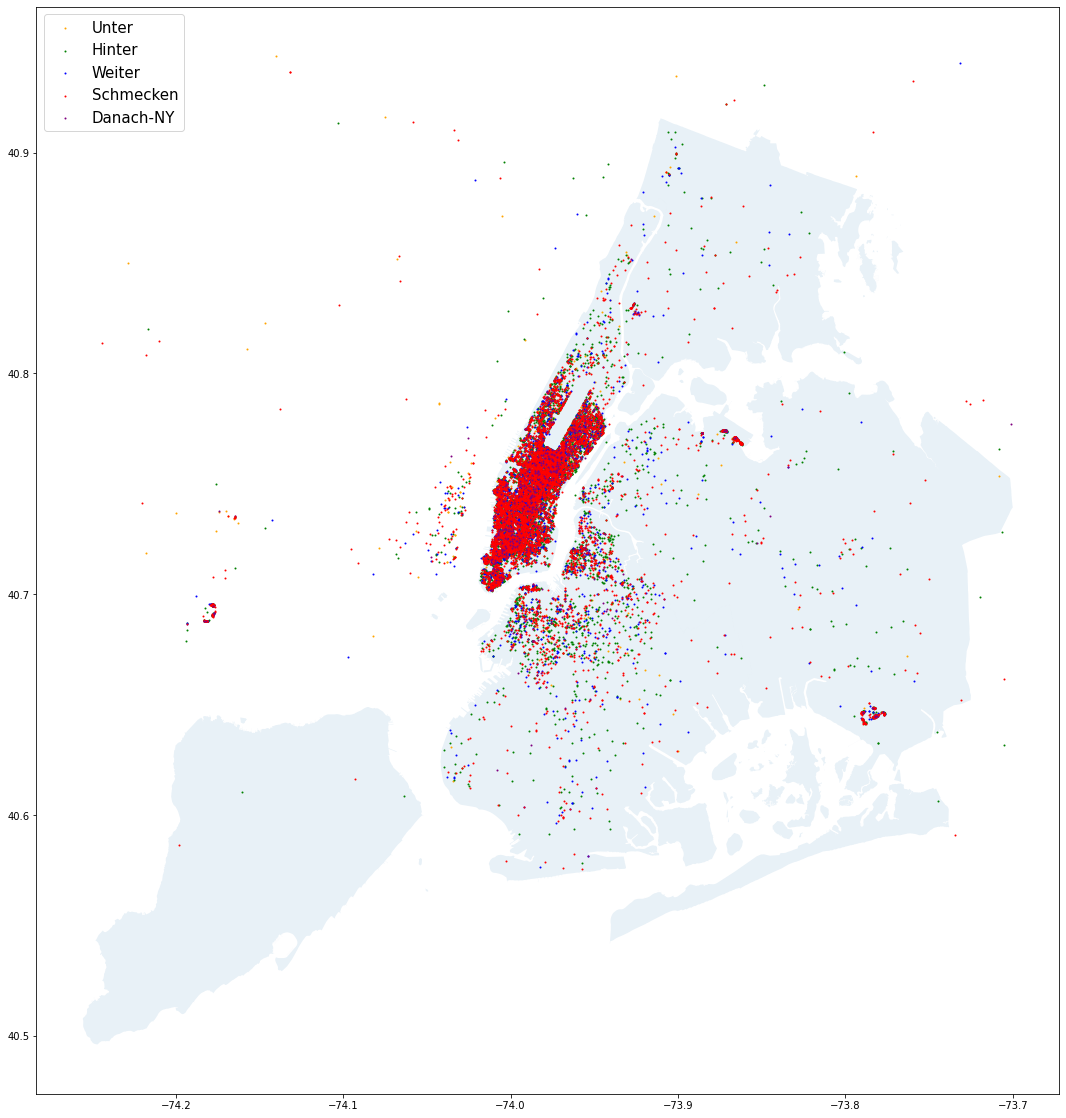

In [10]:
uber_data_may = spark_session.read.option("header","true").csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/uber-raw-data-may14.csv')
uber_data_may = uber_data_may.rdd.filter(lambda x: (-74.2619 < float(x["Lon"]) < -73.7) 
                                                      and (40.4877 < float(x["Lat"]) < 40.9478))\
                                            .filter(lambda x: x["Date/Time"].split(" ")[0] == "5/1/2014").toDF()
plot_locations(uber_data_may)

# 4) Company distribution within boroughs

In [14]:
def company_dis(data):
    zones = spark_session.read.option("header","true").csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/taxi-zone-lookup.csv')
    comp_map = {"B02512": "Unter", "B02598": "Hinter", "B02617": "Weiter", "B02682": "Schmecken", 
            "B02764": "Danach-NY", "B02765": "Grun", "B02835": "Dreist", "B02836": "Drinnen"}
    base_boroughs = data.join(zones, data.locationID == zones.LocationID)\
                                            .select(data.Dispatching_base_num, zones.Borough)
    base_boroughs = base_boroughs.rdd.map(lambda x: (comp_map[x["Dispatching_base_num"]], x["Borough"]))\
                                                                                .toDF(["base","borough"])
    boroughs = zones.select("Borough").distinct().collect()
    grouped_boroughs = base_boroughs.groupBy("borough","base").count()
    for b in boroughs:
        plt.figure()
        filtered = grouped_boroughs.filter(b["Borough"] == grouped_boroughs.borough).collect()
        occ = []
        comp = []
        borough = b["Borough"]
        for row in filtered:
            occ.append(row["count"])
            comp.append(row["base"])
        plt.pie(occ, labels=comp)
        plt.title(borough)
        #plt.savefig(f"results/distribution_{borough}.png")

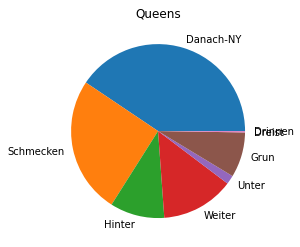

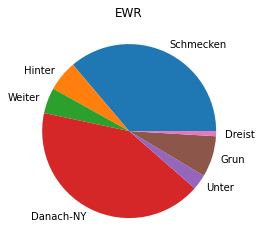

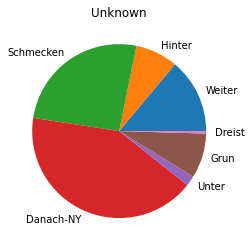

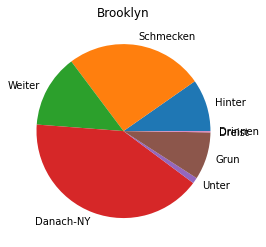

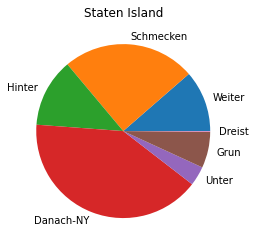

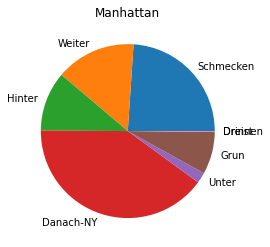

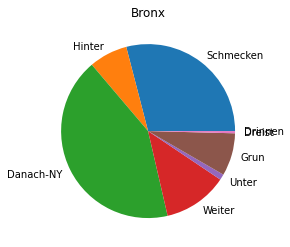

In [15]:
company_dis(uber_data_janJune)

In [16]:
spark_session.stop()

# Scalability

In [19]:
import timeit

In [23]:
%%capture
time = []
for i in range(1, 7):
    
    spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.74:7077") \
        .appName("uber_application")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max",i)\
        .config("spark.cores.min",i)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()
    
    start = timeit.default_timer();
    
    plot_all();
    uber_data_janJune = spark_session.read.option("header","true").csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/uber-raw-data-janjune-15.csv')
    find_most_popular_comp(uber_data_janJune).show();
    uber_data_may = spark_session.read.option("header","true").csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/uber-raw-data-may14.csv')
    uber_data_may = uber_data_may.rdd.filter(lambda x: (-74.2619 < float(x["Lon"]) < -73.7) 
                                                          and (40.4877 < float(x["Lat"]) < 40.9478))\
                                                .filter(lambda x: x["Date/Time"].split(" ")[0] == "5/1/2014").toDF()
    plot_locations(uber_data_may);
    company_dis(uber_data_janJune);
    spark_session.stop()
    stop = timeit.default_timer();
    time.append(stop - start)
    print(f"{i}: {stop - start}")

In [24]:
time

[817.7754937519785,
 692.2497979949694,
 430.5290713730501,
 406.3736568290042,
 364.66341360198567,
 317.58479245199123]